# DATA 605 Homework 2
Author: Kevin Havis

In [55]:
from scipy.stats import binom, poisson, hypergeom, geom, uniform, expon, norm
import scipy.special
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

## Problem 1

### 1. Bayesian

A new credit scoring system has been developed to predict the likelihood of loan defaults. The system has a 90% sensitivity, meaning that it correctly identifies 90% of those who will default on their loans. It also has a 95% specificity, meaning that it correctly identifies 95% of those who will not default.The default rate among borrowers is 2%.

Given these prevalence, sensitivity, and specificity estimates, what is the probability that a borrower flagged by the system as likely to default will actually default? If the average loss per defaulted loan is $200,000 and the cost to run the credit scoring test on each borrower is $500, what is the total first-year cost for evaluating 10,000 borrowers?

Our probability of any given borrower flagged by our system defaulting, $P(D^+|T^+)$, can be represented as the *Positive Predictive Value* or PPV, which is commonly reprsented as;

$$
PPV = P(D^+|T^+) = \frac{prevalence * sensitivity}{(prevalence * sensitivity) + [(1-prevalence)*(1-specificity)]}
$$

Given we know the prevalence, sensitivity, and specificity, we can calculate this probability to be 0.2687


In [3]:
def calculate_ppv(prior=0.02, sensitivity=0.9, specificity=0.95):
    """Bayesian caculation of positive predictive value given pior/prevalence, sensitivity, and specificity"""

    return (prior * sensitivity) / (
        (prior * sensitivity) + ((1 - prior) * (1 - specificity))
    )


calculate_ppv()

0.2686567164179103

To further understand the cost of running this system, and assuming no negative impact from false positives, we can use the sensitivity (how often the control correctly detects fraud) to calculate expected values, $E(x)$, of running this system as;

$$
E(x) = (\$200,000 * prior * sensitivity) - \$500
$$

In this way, we are framing saving the value of the defaulted loans as earning the same value, times the probability of correctly detecting a potential default (sensitivity times the prior), less the cost of running the check.

We will compute this for the expected number of borrowers, $n$, to evaluate in a given year.

In [39]:
def calculate_system_cost(
    prior=0.02, sensitivity=0.9, value=200000, overhead=500, n=10000
):
    """Calculate the earned value of correctly predicting a defaulted loan"""

    # Losses from defaults
    actual_defaults = prior * n
    default_cost = actual_defaults * value

    # Losses from new system
    system_cost = overhead * n

    total_cost = default_cost + system_cost

    # Total costs
    print(f"Total costs in year first of implementation: -${total_cost:,.0f}")

    net = ((value * prior * sensitivity) - overhead) * n
    print(f"Net benefit of implementation new system (including costs): ${net:,.0f}")


calculate_system_cost()

Total costs in year first of implementation: -$45,000,000
Net benefit of implementation new system (including costs): $31,000,000


With a net expected value of $31,000,000 over the year, we would certainly want to implement this system.

### 2. Binomial

The probability that a stock will pay a dividend in any given quarter is 0.7. What is the probability that the stock pays dividends exactly 6 times in 8 quarters? What is the probability that it pays dividends 6 or more times? What is the probability that it pays dividends fewer than 6 times? What is the expected number of dividend payments over 8 quarters? What is the standard deviation?

The probability of a stock paying dividends in exactly six quarters, $P(k)$, out of eight total quarters, $n$, can be calculated using the binomial distribution.

$$
P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

In [5]:
def stock_dividends(p=0.7, k=6, n=8):
    return (
        ((math.factorial(n)) / (math.factorial(n - k) * math.factorial(k)))
        * (p**k)
        * ((1 - p) ** (n - k))
    )


stock_dividends()

0.29647547999999996

We can see the probability of getting dividends exactly six of the eight months is 0.2965.

We will use `scipy` implementation of binomial probabilities for the additional questions.

In [ ]:
def more_stock_dividends(p=0.7, n=8, k=6):
    # 6 or more times?
    binom_dist = binom(n=n, p=p)
    prob_6 = sum(binom_dist.pmf(k=range(k, n + 1)))  # k to n dividends
    print(f"Probability of more than {k} dividends in {n} quarters: {prob_6}")

    # Fewer than 6?
    binom_dist = binom(n=n, p=p)
    prob_less_6 = sum(binom_dist.pmf(k=range(0, k)))  # less than k dividends

    print(f"Probability of less than {k} dividends in {n} quarters: {prob_less_6:.3f}")

    # Mean dividends in eight quarters?
    prob_mean = binom_dist.mean()
    print(f"Expected (mean) number of dividends in {n} quarters: {prob_mean:.3f}")

    # Stddev
    prob_stddev = binom_dist.std()
    print(f"Standard deviation of dividends in {n} quarters: {prob_stddev:.3f}")


more_stock_dividends()


Probability of more than 6 dividends in 8 quarters: 0.5517738100000001
Probability of less than 6 dividends in 8 quarters: 0.448
Expected (mean) number of dividends in 8 quarters: 5.600
Standard deviation of dividends in 8 quarters: 1.296


### 3. Poisson

A financial analyst notices that there are an average of 12 trading days each month when a certain stock’s price increases by more than 2%. What is the probability that exactly 4 such days occur in a given month? What is the probability that more than 12 such days occur in a given month? How many such days would you expect in a 6-month period? What is the standard deviation of the number of such days? If an investment strategy requires at least 70 days of such price increases in a year for profitability, what is the percent utilization and what are your recommendations?

Our first instinct when considering discrete events over time should be to consider the Poisson distribution. The Poisson distribution is a variation of the binomial distribution that helps us understand the probabilities of a given event $X$ resulting in a specific outcome $k$ within a specific time period $t$. 

The Poisson probability function allows us to simplify the model such that we can concern ourselves only with the average rate for the given time period (i.e. the rate of $k$ per $t$), $\lambda$, and the number of outcomes we are expecting, $k$.

$$
P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

In [ ]:
def price_fluctuations(k=12, t=30, l=12):
    # Calculate lambda
    # l = k / t
    print(f"Lambda (average events per month): {l}")

    # Calculate the distribution
    poisson_dist = poisson(mu=l)

    # Exactly four days
    prob_exactly_4 = poisson_dist.pmf(4)
    print(f"Probability of exactly 4 price fluctuations: {prob_exactly_4:.4f}")

    # More than twelve
    prob_more_than_12 = 1 - poisson_dist.cdf(12)
    print(f"Probability of more than 12 price fluctuations: {prob_more_than_12:.4f}")

    # Six months
    days_with_increase = l * 6
    print(f"Expected number of days to see an increase: {days_with_increase}")

    # Standard deviation
    std_dev = poisson_dist.std()
    print(f"Standard deviation of daily price fluctuations: {std_dev:.4f}")

    # At least 70 per year
    n_days = 70
    prob_at_least_70_per_year = 1 - poisson.cdf(n_days, mu=l * 12)
    print(
        f"Probability of at least 70 price fluctuations per year: {prob_at_least_70_per_year:.4f}"
    )


results = price_fluctuations()

Lambda (average events per month): 12
Probability of exactly 4 price fluctuations: 0.0053
Probability of more than 12 price fluctuations: 0.4240
Expected number of days to see an increase: 72
Standard deviation of daily price fluctuations: 3.4641
Probability of at least 70 price fluctuations per year: 1.0000


With our trading strategy having a 100% of meeting the criteria, we can recommend adding this stock to our portfolio.

### 4. Hypergeometric
A hedge fund has a portfolio of 25 stocks, with 15 categorized as high-risk and 10 as low-risk. The fund manager randomly selects 7 stocks to closely monitor. If the manager selected 5 high-risk stocks and 2 low-risk stocks, what is the probability of selecting exactly 5 high-risk stocks if the selection was random? How many high-risk and low-risk stocks would you expect to be selected?

We can use `scipy` to construct our hypergeometric distribution, which has parameters $M$ for total choices, $n$ for "success" choices (high risk stocks in this case), and $N$ for the number we are randomly choosing from $M$ *without replacement*.

We will use the probability mass functio to determine the probability of choosing exaclty five high risk stocks, as well as the average expected number of high risks stocks, given seven random selections.

In [ ]:
def high_risk_stocks(x, M=25, n=15, N=7):
    hyper = hypergeom(M, n, N)
    p = hyper.pmf(x)
    print(f"Probability of selecting {N} high risk stocks: {p:.3f}")
    print(f"Mean high risk stocks: {hyper.mean()}")
    print(f"Mean low risk stocks: {N - hyper.mean()}")


# Probability of selecting exactly 5
high_risk_stocks(5)

Probability of selecting 7 high risk stocks: 0.281
Mean high risk stocks: 4.2
Mean low risk stocks: 2.8


### 5. Geometric

The probability that a bond defaults in any given year is 0.5%. A portfolio manager holds this bond for 10 years. What is the probability that the bond will default during this period? What is the probability that it will default in the next 15 years? What is the expected number of years before the bond defaults? If the bond has already survived 10 years, what is the probability that it will default in the next 2 years?

We will cynically frame this problem as a default being a success, and will build our geometric distribution accordingly. Since we want to the probability of default as time goes on, we will use the cumulative distribution function of the geometric distribution. This tells us the probability of default *within* the given timeframe.

The last part of the question, where we are asked to solve for default in the 11th or 12th year given ten have passed, will need to be the difference in probability between the 12th and the 10th year.

In [ ]:
def bond_default(p=0.005, t_1=10, t_2=15, t_3=12):
    geometric = geom(p)
    p_t = geometric.cdf(t_1)
    print(f"Probability of default in {t_1} years : {p_t:.3f}")

    p_t2 = geometric.cdf(t_2)
    print(f"Probability of default in {t_2} years : {p_t2:.3f}")

    p_t3 = geometric.cdf(t_3) - geometric.cdf(10)
    print(f"Probability of default in next two years given ten have passed: {p_t3:.3f}")
    print(f"Expected number of years before default: {1 / p:.3f}")


bond_default()


Probability of default in 10 years : 0.049
Probability of default in 15 years : 0.072
Probability of default in next two years given ten have passed: 0.009
Expected number of years before default: 200.000


### 6. Poisson

A high-frequency trading algorithm experiences a system failure about once every 1500 trading hours. What is the probability that the algorithm will experience more than two failures in 1500 hours? What is the expected number of failures?

Using the Poisson distribution, we can define its single parameter, the rate of failure $\lambda$, to be $1/1500$, and construct the distribution from there.

We can determine the expected number of failures, and probability of that exceeding two, using the mean and cumulative distributive function respectively.

In [ ]:
def algo(k=1, t=1500):
    l = k / t  # lambda

    poisson_dist = poisson(mu=1 / l)

    print(
        f"Probability of more than two failures in 1500 hours: {1 - poisson_dist.cdf((2)):.3f}"
    )
    print(f"Expected number of failures in {t} hours: {poisson_dist.mean():.3f}")


algo()

Probability of more than two failures in 1500 hours: 1.000
Expected number of failures in 1500 hours: 1500.000


### 7. Uniform Distribution
An investor is trying to time the market and is monitoring a stock that they believe has an equal chance of reaching a target price between 20 and 60 days. What is the probability that the stock will reach the target price in more than 40 days? If it hasn’t reached the target price by day 40, what is the probability that it will reach it in the next 10 days? What is the expected time for the stock to reach the target price?

If the stock has an equal chance of reaching a target price, we can model this with a uniform distribution. Using `scipy.stats.randint`, we can select our low to be the minimum expected date range (20), and the corresponding high (60).

We then examine the distribution to determine the probabilities of observing the target price within that time frame.

In [76]:
def target_price(low=20, high=60):
    uni = uniform(loc=low, scale=high - low)

    print(f"Probability of target price in 40+ days : {1 - uni.cdf(40)}")
    print(
        f"Probability of target price in next 10 days, given 40 have passed : {(uni.cdf(50) - uni.cdf(40)) / (1 - uni.cdf(40))}"  # Conditional probability
    )
    # Could also have used uniform.cdf(40, 50-40)
    print(f"Mean number of days to hit target price : {uni.mean()}")


target_price()


Probability of target price in 40+ days : 0.5
Probability of target price in next 10 days, given 40 have passed : 0.5
Mean number of days to hit target price : 40.0


### 8. Exponential Distribution
A financial model estimates that the lifetime of a successful start-up before it either goes public or fails follows an exponential distribution with an expected value of 8 years. What is the expected time until the start-up either goes public or fails? What is the standard deviation? What is the probability that the start-up will go public or fail after 6 years? Given that the start-up has survived for 6 years, what is the probability that it will go public or fail in the next 2 years?

Considering an exponential distribution only has one parameter, the rate of an event $\lambda$, we simply need to calculate it and construct our probability density function. We can then calculate the probabilities of all the described events occcuring.

Note: We are assuming language such as "given" is indicating conditional probability $P(A|B)$

In [ ]:
def start_up(mu=8):
    expo = expon(scale=mu)

    print(f"Expected time for a startup to go public or fail: {expo.mean()} years")
    print(f"Expected standard deviation: {expo.std()} years")
    print(
        f"Probability of going public or failing after the 6th year: {1 - expo.cdf(6):.3f}"
    )
    print(
        f"Probability of going public of failing in next two years after six: {(expo.cdf(8) - expo.cdf(6)) / (1 - expo.cdf(6)):.3f}"  # Conditional probability
    )


start_up()


Expected time for a startup to go public or fail: 8.0 years
Expected standard deviation: 8.0 years
Probability of going public or failing after the 6th year: 0.472
Probability of going public of failing in next two years after six: 0.221


## Problem 2

### 1. Product Selection
A company produces 5 different types of green pens and 7 different types of red pens. The marketing team needs to create a new promotional package that includes 5 pens. How many different ways can the package be created if it contains fewer than 2 green pens?

If we are required to build a package that contains *fewer than two* green pens, that means we can have a maximum of one green pen in a package. This leaves us two outcomes; A package of only red pens, or a package of one green pen and four red pens.

Now, assuming that each pen itself is unique, we now must consider the *possibilities* of each of our two cases. We can do this using the binomial coefficient formula;

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$

In [13]:
def binom_coeff(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))


def pen_packing():
    # Case 1 One green pen
    green_1 = binom_coeff(5, 1)
    red_1 = binom_coeff(7, 4)
    total_1 = green_1 * red_1

    # Case 2 No green pen
    red_2 = binom_coeff(7, 5)
    total_2 = red_2

    total_possibilities = total_1 + total_2

    print(f"Total possible combinations of red and green pens: {total_possibilities}")


pen_packing()


Total possible combinations of red and green pens: 196.0


### 2. Team Formation for a Project

A project committee is being formed within a company that includes 14 senior managers and 13 junior managers. How many ways can a project team of 5 members be formed if at least 4 of the members must be junior managers?

Similar to the last problem, we can use the binomial coefficient to calculate this. We have the same number of cases in this problem; given at least 4 members must be junior, we either have one or zero senior managers on the 5 member committee.

In [14]:
def project_committee():
    seniors = 14
    juniors = 13

    # Case 1 One senior
    senior_1 = binom_coeff(seniors, 1)
    junior_1 = binom_coeff(juniors, 4)
    total_1 = senior_1 * junior_1

    # Case 2 No senior
    junior_2 = binom_coeff(juniors, 5)
    total_2 = junior_2

    total_possibilities = total_1 + total_2

    print(f"Total possible combinations of committee members: {total_possibilities}")


project_committee()


Total possible combinations of committee members: 11297.0


### 3. Marketing Campaign Outcomes

A marketing campaign involves three stages: first, a customer is sent 5 email offers; second, the customer is targeted with 2 different online ads; and third, the customer is presented with 3 personalized product recommendations. If the email offers, online ads, and product recommendations are selected randomly, how many different possible outcomes are there for the entire campaign?

This is a simple permutation and we can calculate it by multiplying the $n$ number of options for each $m$ stage. In this case, we would multiply $5 \times 2 \times 3 = 30$, meaning we have 30 potential outcomes for a customer through the entire campaign.

### 4. Product Defect Probability

A quality control team draws 3 products from a batch of size N without replacement. What is the probability that at least one of the products drawn is defective if the defect rate is known to be consistent? 

Given we are sampling without replacement, we cannot use a binomial coefficient to calculate this. We must instead use the hypergeometric, which has parameters;

-  $N$, number of products in the batch
-  $k$ number of total defects expected in the batch
-  $n$ number of products we sample
-  $x$ the number of defects in our sample

Note that we could calculate $k = p \times N$ as we know the consistent rate $p$, but we will leave as $k$ for simpler expression.

In this scenario, $N=N$, $k=k$, $n=3$, and $x\ge 1$. Using these as parameters to the generic hypergeometric formula, we get;


$$
H(x \ge 1: N, 3, k) = H(x=1: N, 3, k) + H(x=2: N, 3, k) + H(x=3: N, 3, k)
$$

where each $H(x: N, n, k) = (_kC_x \times (_{N-k}C_{n-x})) / _NC_n$

### 5. Business Strategy Choices

A business strategist is choosing potential projects to invest in, focusing on 17 high-risk, high-reward projects and 14 low-risk, steady-return projects.

#### Step 1: How many different combinations of 5 projects can the strategist select? 

We can use our earlier binomial coefficient function to calculate the combination of 5 projects given 17 high risk and 14 low risk.

With a portfolio of five projects, we have 5 cases to calculate combinations for; five high risk and no low risk, four high risk and one low, and so on.

Thus we will define $k$ as the number of high risk selected, and $n-k$ as the number of low risk. We will calculate the sum of $k$ combinations of high and low risk projects.

In [15]:
def portfolio(n=5, k=5, high=17, low=14):
    # Number of cases we have - need a different variable to avoid decrementing accidentally
    cases = k
    outcomes = []

    for _ in range(cases):
        outcomes.append(
            binom_coeff(high, k)  # High risk
            * binom_coeff(low, (n - k))
        )  # Low risk
        k -= 1  # Reduce high risk / increase low risk by 1

    print(f"Total possible outcomes: {sum(outcomes)}")


portfolio()

Total possible outcomes: 167909.0


#### Step 2: How many different combinations of 5 projects can the strategist select if they want at least one low-risk project? 

We can solve this the same way as before, but in this case we have $k-1$ cases since we always want at least one low-risk project.

In [16]:
portfolio(k=4)

Total possible outcomes: 161721.0


### 6. Event Scheduling

A business conference needs to schedule 9 different keynote sessions from three different industries: technology, finance, and healthcare. There are 4 potential technology sessions, 104 finance sessions, and 17 healthcare sessions to choose from. How many different schedules can be made? Express your answer in scientific notation rounding to the hundredths place.

We need to set this up as a combination of $C(4, t)$, $C(17, h)$, and $C(104, f)$, which represent the combinations of $t$ technology sessions, $h$ healthcare sessions, and $f$ finance sessions, such that $t+f+h=9$. This is essentially a dynamic binomial coefficient problem from this point out - the important distinction is that the typical $n$ choose $k$ parameters are not static (given the number of $k$ for each type of session depends on how many slots we still have to fill).

With this in mind, we will loop through each iteration such that we have at least one of every session booked and combine the combinations of each together to get our final answer.



In [17]:
def conference_schedule(n_session=9, t_session=4, h_session=17, f_session=104):
    schedules = 0

    # Loop through every iteration of t, h, and f
    for t in range(
        1, min(t_session, n_session - 2) + 1
    ):  # For every option of t given we need to reserve n-2 for other industries
        for f in range(
            1, min(f_session, n_session - t - 1) + 1
        ):  # For every option of finance
            h = n_session - t - f  # Finally, remaining for healthcare

            if h > 0 and h <= h_session:  # Calculate combination for a given t, h, f
                t_ways = scipy.special.comb(t_session, t, exact=True)
                f_ways = scipy.special.comb(f_session, f, exact=True)
                h_ways = scipy.special.comb(h_session, h, exact=True)

                total_ways = t_ways * f_ways * h_ways
                schedules += total_ways

    print(f"Total combinations: {schedules:.2e}")


conference_schedule()


Total combinations: 2.83e+12


### 7. Book Selection for Corporate Training

An HR manager needs to create a reading list for a corporate leadership training program, which includes 13 books in total. The books are categorized into 6 novels, 6 business case studies, 7 leadership theory books, and 5 strategy books.

#### Step 1: If the manager wants to include no more than 4 strategy books, how many different reading schedules are possible? Express your answer in scientific notation rounding to the hundredths place. 

Similar to the last problem, we must find the aggregate combination of 13 different books from 4 different genres, making sure we don't innundate the cirriculum with strategy books (no more than 4). We let $n$ novels, $b$ business case studies, $l$ leadership books, and $s$ strategy books combine such that $n+b+l+s = 13$, and for each iteration we calculate the aggregate *n choose k* combinations.

**Note**: We are assuming that we'd like at least one of each genre of book for variety

In [18]:
def curriculum(n_books=6, b_books=6, l_books=7, s_books=5, k=13):
    schedule = 0
    max_strategy_books = 4

    # Loop through every possible distribution
    for n in range(1, min(n_books, k - 2) + 1):  # At least 1 of each type required
        for b in range(
            1, min(b_books, k - n - 1) + 1
        ):  # Need to reserve at least 1 each for s and l
            for s in range(
                1, min(max_strategy_books, k - n - b) + 1
            ):  # Strategy book constraint
                l = k - n - b - s  # Remaining slots for leadership books

                # Check if the distribution is valid
                if l >= 1 and l <= l_books:
                    n_ways = scipy.special.comb(n_books, n, exact=True)
                    b_ways = scipy.special.comb(b_books, b, exact=True)
                    l_ways = scipy.special.comb(l_books, l, exact=True)
                    s_ways = scipy.special.comb(s_books, s, exact=True)

                    total_ways = n_ways * b_ways * l_ways * s_ways
                    schedule += total_ways

    print(f"Total reading schedules: {schedule:.2e}")
    return schedule


curriculum()

Total reading schedules: 2.38e+06


2376985

#### Step 2: If the manager wants to include all 6 business case studies, how many different reading schedules are possible? Express your answer in scientific notation rounding to the hundredths place. 

If we always require 6 of 6 business case studies to be included in the cirriculum, then there is only one way to do that. As such, we can just simplify our previous algorithim to only range through the remaining seven options for the other three genres.

**Note**: We are again assuming that we'd like at least one of each genre of book for variety

In [19]:
def curriculum_bus_studies(n_books=6, b_books=6, l_books=7, s_books=5, k=13):
    schedule = 0

    # Reduce k by 6 to account for fixed b_books
    k = k - b_books

    # Loop through every possible distribution
    for n in range(1, min(n_books, k - 1) + 1):  # At least 1 of each type required
        # for b in range(1, min(max_business_books, k-n-1) + 1): # we are fixing b_books
        for s in range(1, min(s_books, k - n) + 1):
            l = k - n - s  # Remaining slots for leadership books

            # Check if the distribution is valid
            if l >= 1 and l <= l_books:
                n_ways = scipy.special.comb(n_books, n, exact=True)
                b_ways = scipy.special.comb(b_books, b_books, exact=True)  # always 1
                l_ways = scipy.special.comb(l_books, l, exact=True)
                s_ways = scipy.special.comb(s_books, s, exact=True)

                total_ways = n_ways * b_ways * l_ways * s_ways
                schedule += total_ways

    print(f"Total reading schedules: {schedule:.2e}")
    return schedule


curriculum_bus_studies()

Total reading schedules: 2.90e+04


28987

### 8. Product Arrangement

A retailer is arranging 10 products on a display shelf. There are 5 different electronic gadgets and 5 different accessories. What is the probability that all the gadgets are placed together and all the accessories are placed together on the shelf? Express your answer as a fraction or a decimal number rounded to four decimal places.

Considering the ordered sets of gadgets and accessories aligned on a display shelf, we have a permutation problem on our hands, specifically permutation without replacement as we are dealing with the ordering of physical objects.

With all five of each group placed together, we can say there are two cases in which this happens; all five gadgets on the left and accessories on the right, or all five accessories on the left and the gadgets on the right. With this in mind, we can calculate the permutations for each of these scenarios, multiply them, and then divide by the total number of permutations of any 10 objects to find the probability.

In [ ]:
def permuation_no_replace(n=10, r=10, subsets=2):
    """Calculates probability of arranging n of r items by subset"""
    n_subset, r_subset = int(n / subsets), int(r / subsets)  # Divide by subset

    # Calculate the number of ways you can group 5 choose 5
    ordered_perms = (
        2 * (math.factorial(n_subset) / (math.factorial(n_subset - r_subset))) ** 2
    )  # raise to 2 to account for both gadgets and accessories
    # and by 2 to account for the left-right / right-left position

    total_perms = math.factorial(n) / (math.factorial(n - r))

    p = ordered_perms / total_perms

    print(f"Probability of arranging ordered subsets: {p:.4f}")


permuation_no_replace()

Probability of arranging ordered subsets: 0.0079


#### 9. Expected Value of a Business Deal

A company is evaluating a deal where they either gain $4 for every successful contract or lose $16 for every unsuccessful contract. A "successful" contract is defined as drawing a queen or lower from a standard deck of cards. (Aces are considered the highest card in the deck.)

#### Step 1: Find the expected value of the deal. Round your answer to two decimal places. Losses must be expressed as negative values. 

To find the expected value of this questionable business strategy, we will need to calculate the probability of drawing a "successful" card from a standard 52 card playing deck, and weigh that (and the payout) against a "losing" card. 

We will assume that after each draw, the drawn card is replaced in the deck, and the deck then shuffled.

In [21]:
def texas_hedge_em(n, win=4, loss=16):
    ranks = 13
    suits = 4
    cards = ranks * suits
    winning_ranks = 11
    winning_cards = winning_ranks * suits

    p_win = winning_cards / cards
    p_loss = 1 - p_win

    win_ev = win * p_win
    loss_ev = loss * p_loss * -1

    exp_val = (win_ev) + (loss_ev)

    print(f"Expected value of winning: ${win_ev:.2f}")
    print(f"Expected value of losing: ${loss_ev:.2f}")
    print(f"Total Expected value of the bet: ${exp_val:.2f}")
    print(f"Total Expected value over {n} bets: ${(n * exp_val):.2f}")


texas_hedge_em(1)


Expected value of winning: $3.38
Expected value of losing: $-2.46
Total Expected value of the bet: $0.92
Total Expected value over 1 bets: $0.92


#### Step 2: If the company enters into this deal 833 times, how much would they expect to win or lose? Round your answer to two decimal places. Losses must be expressed as negative values. 

In [22]:
texas_hedge_em(833)

Expected value of winning: $3.38
Expected value of losing: $-2.46
Total Expected value of the bet: $0.92
Total Expected value over 833 bets: $768.92


## Problem 3

### 1. Supply Chain Risk Assessment

Let $X_1, X_2, ..., X_n$ represent the lead times (in days) for the delivery of key components from $n=5$ different suppliers. Each lead time is uniformly distributed across a range of 1 to $k=20$ days, reflecting the uncertainty in delivery times. Let $Y$ denote the minimum delivery time among all suppliers. Understanding the distribution of $Y$ is crucial for assessing the earliest possible time you can begin production. Determine the distribution of $Y$ to better manage your supply chain and minimize downtime.

Initially I was not sure how to solve this problem so I decided to simulate it.

We will take $n$ suppliers and simulate $t$ collective deliveries (i.e. requesting a component from each supplier simultaneously). Given we know the lead time is uniformly distributed between 1 and 20 (inclusive) days, for each collective delivery, we will randomly select an integer for each $n$ supplier to represent lead days.

The minimum delivery time for each delivery is the **max lead time for any single supplier, assuming work cannot begin without all components**. That is to say, if four suppliers can get us the components we need overnight, but the fifth will require 20 days, then the earliest we can begin production is on the 21st day. We record this maximum for each collective delivery.

Finally, we run the simulation and plot the discrete distribution as a histogram of minimum collective delivery lead times.



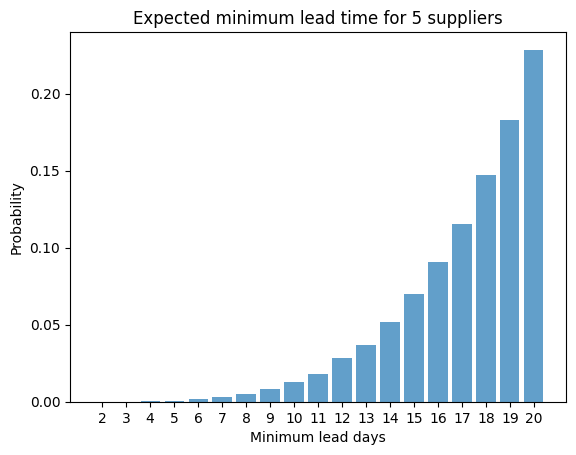

In [23]:
def supply_chain(n=5, t=100000):
    # Minimum lead for a collective delivery
    Y = []

    # Simulate t trials
    for _ in range(t):
        lead_days = []

        # Lead days for all n suppliers
        for _ in range(n):
            lead_days.append(random.randint(1, 20))

        # The individual max lead is the minimum delivery lead
        Y.append(max(lead_days))

    Y_array = np.array(Y)
    min_days, counts = np.unique(Y_array, return_counts=True)

    # Calculate probabilities of each lead day
    P = counts / len(Y_array)

    fig, ax = plt.subplots()
    ax.bar(min_days, P, alpha=0.7)
    ax.set_xticks(min_days)
    ax.set_xlabel("Minimum lead days")
    ax.set_ylabel("Probability")
    ax.set_title(f"Expected minimum lead time for {n} suppliers")


supply_chain()

With our simulation complete, we can see that the most common minimum lead time for a complete delivery is 20 days, followed by 19, and so on. This intuitively makes sense given how we defined the "minimum lead time" - it is the max lead for any one supplier given a uniformly distributed range of 1-20 lead days, and we should expect the most common maximum to be the max of the uniform range itself.

### 2. Maintenance Planning for Critical Equipment

Your organization owns a critical piece of equipment, such as a high-capacity photocopier (for a law firm) or an MRI machine (for a healthcare provider). The manufacturer estimates the expected lifetime of this equipment to be 8 years, meaning that, on average, you expect one failure every 8 years. It's essential to understand the likelihood of failure over time to plan for maintenance and replacements.

#### a. Geometric Model

Calculate the probability that the machine will not fail for the first 6 years. Also, provide the expected value and standard deviation. This model assumes each year the machine either fails or does not, independently of previous years.

We will first use the geometric distribution to help us answer questions regarding the probability of the first event occuring (machine failure) out of some amount of trials (years). The geometric has one parameter, $p$, which is the probability of machine failure in any one year, which in this case is $\frac{1}{8}$.

To determine the probability of the machine lasting at least 6 years, we can use the survival function ($1-cdf(x)$) to calculate the mass of the "tail" of the distribution after the 6th year.

For a geometric distribution the mean is $\frac{1}{p}$, which in this case is 8 years. We can use the distribution to then calculate the standard deviation.


In [24]:
def maintenance_geom(p, n_years):
    geom_dist = geom(p)
    mean = geom_dist.mean()
    std = geom_dist.std()

    # Prob of not failing in first 6
    # is the survival function of the distribution
    q = geom_dist.sf(n_years)

    print(f"Probability of machine not failing in first {n_years} years: {q:.3f}")
    print(f"Expected value of the machine lifetime: {mean} \u00b1 {std:.3f} years")


maintenance_geom((1 / 8), 6)

Probability of machine not failing in first 6 years: 0.449
Expected value of the machine lifetime: 8.0 ± 7.483 years


#### b. Exponential Model

Calculate the probability that the machine will not fail for the first 6 years. Provide the expected value and standard deviation, modeling the time to failure as a continuous process.

The exponential distribution can be thought of as a continuous version of the geometric distribution. The main difference is that the exponential distribution is considering how much time passes before an event occurs, as opposed to which discrete unit of time a Benoulli trial success occurs in (as the geometric distribution does).

We should expect the results between the exponential and geometric model to be similar, with the exception of standard deviation; the standard deviation for the exponential distribution is always the same as the mean.

In [25]:
def maintenance_exp(p, n_years):
    e_dist = expon(scale=1 / p)
    mean = e_dist.mean()
    std = e_dist.std()
    q = e_dist.sf(n_years)

    print(f"Probability of machine not failing in first {n_years} years: {q:.3f}")
    print(f"Expected value of the machine lifetime: {mean} \u00b1 {std} years")


maintenance_exp((1 / 8), 6)

Probability of machine not failing in first 6 years: 0.472
Expected value of the machine lifetime: 8.0 ± 8.0 years


#### c. Binomial Model

Calculate the probability that the machine will not fail during the first 6 years, given that it is expected to fail once every 8 years. Provide the expected value and standard deviation, assuming a fixed number of trials (years) with a constant failure probability each year.

Taking a binomial approach to this situation is a relatively simple way to estimate it; we're essentially treating the machine either failing or not failing in a given year as an independent event. In essence, each year we roll an eight sided die and see if it lands on a one to determine if the machine fails.

Our parameters for a binomial distribution are the $n$ number of years and $k$ machine failures we expect (one, in this case).

In [26]:
def maintenance_binom(n, k, n_years):
    p = k / n

    b_dist = binom(n, p)
    mean = b_dist.mean()
    std = b_dist.std()
    q = b_dist.sf(n_years)

    print(f"Probability of machine not failing in first {n_years} years: {q:.3f}")
    print(f"Expected value of the machine lifetime: {mean} \u00b1 {std:.3f} years")


maintenance_binom(8, 7, 6)


Probability of machine not failing in first 6 years: 0.736
Expected value of the machine lifetime: 7.0 ± 0.935 years


It is interesting to observe the difference in probability using the binomial distribution, compared to the geometric / exponential. It is a good reminder that we should be thoughtful and selective of our models, and to be cautious to not think of these results as a singlular truth.

#### d. Poisson Model

Calculate the probability that the machine will not fail during the first 6 years, modeling the failure events as a Poisson process. Provide the expected value and standard deviation.

The Poisson model represents machine failure as an independent event and determines the probability of $k$ failures in $n$ years. We can again use the `scipy.stats` module to construct the specific distribution and analylze it for the mean and standard deviation, as well as the survival funtion to determine the probability of not failing in the first 6 years.

In [27]:
def maintenance_poiss(k, n_years):
    # k = 1/8 # rate of failure

    p_dist = poisson(mu=k)
    mean = p_dist.mean()
    std = p_dist.std()
    q = p_dist.sf(n_years)

    print(f"Probability of machine not failing in first {n_years} years: {q:.3f}")
    print(f"Expected value of the machine lifetime: {mean} \u00b1 {std:.3f} years")


maintenance_poiss((8), 6)


Probability of machine not failing in first 6 years: 0.687
Expected value of the machine lifetime: 8.0 ± 2.828 years


## Problem 4

### 1. Scenario

You are managing two independent servers in a data center. The time until the next failure for each server follows an exponential distribution with different rates:

- Server A has a failure rate of $\lambda_A = 0.5$ failures per hour
- Server B has a failure rate of $\lambda_B = 0.3$ failures per hour

**Question**: What is the distribution of the total time until both servers have failed at least once? Use the moment generating function (MGF) to find the distribution of the sum of the times to failure.

For an exponential distribution, the MGF takes the form of $M_x(t) = \frac{\lambda}{\lambda - t}$. As such, for the respective servers, we have $M_{xA}(t) = \frac{0.5}{0.5 - t}$ and $M_{xA}(t) = \frac{0.3}{0.3 - t}$

One of the useful properties of moment generating functions is that we can calculate the distribution of the sum of two independent random numbers by multiplying their respective moment generating functions, such that $M_{xZ}(t) = M_{xA}(t) * M_{xB}(t)$

We will leverage this property to find the distribution of both servers failing at least once, first by calculating MGF for each individually, then multiplying them to get the combined distribution.

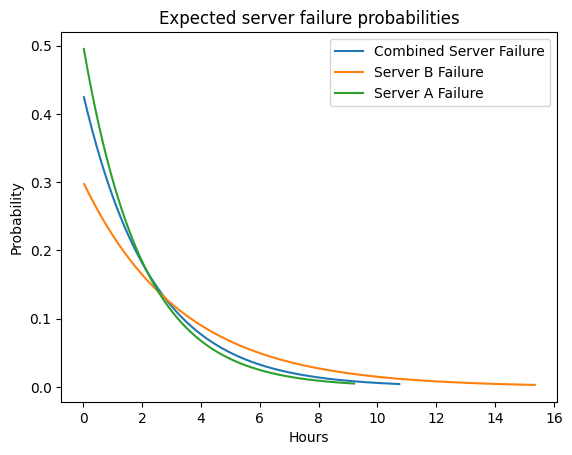

In [28]:
def data_center(mu_a, mu_b):
    # Expon has one parameter mu which is k/n
    # We must convolve the two distributions to calculate their summation
    # M_a * M_b
    # M = lambda / (lambda - t)

    t = 1

    # MGF of Expon
    M_a = mu_a / (mu_a - t)
    M_b = mu_b / (mu_b - t)

    # Convolution using MGFs
    Z = M_a * M_b

    # Create distribution
    dist = expon(scale=1 / Z)
    A = expon(scale=1 / mu_a)
    B = expon(scale=1 / mu_b)

    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
    a = np.linspace(A.ppf(0.01), A.ppf(0.99), 1000)
    b = np.linspace(B.ppf(0.01), B.ppf(0.99), 1000)

    fig, ax = plt.subplots()

    ax.plot(x, dist.pdf(x), label="Combined Server Failure")
    ax.plot(b, B.pdf(b), label="Server B Failure")
    ax.plot(a, A.pdf(a), label="Server A Failure")
    ax.set_title("Expected server failure probabilities")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Probability")
    ax.legend()


data_center(0.5, 0.3)


### 2. Sum of Independent Normally Distributed Random Variables

An investment firm is analyzing the returns of two independent assets, Asset X and Asset Y. The returns on these assets are normally distributed:

- Asset X: $X \sim N(\mu_X = 5\%, \sigma^2_X = 4\%)$
- Asset Y: $Y \sim N(\mu_Y = 7\%, \sigma^2_Y = 9\%)$

**Question**: Find the distribution of the combined return of the portfolio consisting of these two assets using the moment generating function (MGF).


Given we know that both distributions are normally distributed, we can use a special property where the sum of two normal distributions is also normal. As such, we can simply sum the normal distribution parameters, the mean and standard deviation, of both $P(X), P(Y)$, to then calculate our new, combined normal distribution.

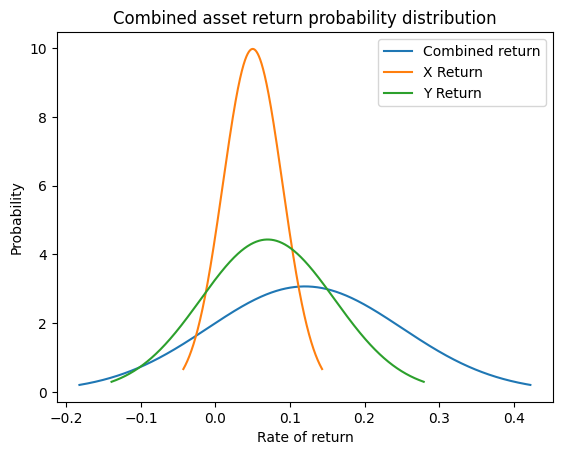

In [29]:
# The sum of two normal distributions is normal
# so we can simply add the means and standard deviations


def combo_portfolio(mu_x, std_x, mu_y, std_y):
    # Z = X+Y
    mu_z = mu_x + mu_y
    std_z = std_x + std_y

    x_dist = norm(mu_x, std_x)
    y_dist = norm(mu_y, std_y)
    dist = norm(mu_z, std_z)

    z = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
    x = np.linspace(x_dist.ppf(0.01), x_dist.ppf(0.99), 1000)
    y = np.linspace(y_dist.ppf(0.01), y_dist.ppf(0.99), 1000)
    fig, ax = plt.subplots()

    ax.plot(z, dist.pdf(z), label="Combined return")
    ax.plot(x, x_dist.pdf(x), label="X Return")
    ax.plot(y, y_dist.pdf(y), label="Y Return")
    # ax.plot(mu_z, 0)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Rate of return")
    ax.set_title("Combined asset return probability distribution")
    ax.legend()


combo_portfolio(0.05, 0.04, 0.07, 0.09)

### 3. Scenario

A call center receives calls independently from two different regions. The number of calls received from Region A and Region B in an hour follows a Poisson distribution:

- Region A: $X_A \sim Poisson(\lambda_A = 3)$
- Region B: $X_B \sim Poisson(\lambda_B = 5)$

**Question**: Find the distribution of the combined return of the portfolio consisting of these two assets using the moment generating function (MGF).


We'll calculate the MGF for each Poisson distribution, then multiply them to get get the MGF of the combined distribution. 

In [ ]:
def poisson_MGF(l, t):
    return np.exp(l * (np.exp(t) - 1))


def call_center(mu_a, mu_b):
    t = 1
    MGF_a = poisson_MGF(mu_a, t)
    MGF_b = poisson_MGF(mu_b, t)

    MGF_z = MGF_a * MGF_b

    print(MGF_z)


call_center(3, 5)

933087.8440725069


## Problem 5

### 1. Customer Retention and Churn Analysis

Scenario: A telecommunications company wants to model the behavior of its customers regarding their likelihood to stay with the company (retention) or leave for a competitor (churn). The company segments its customers into three states:

- State 1: Active customers who are satisfied and likely to stay (Retention state).
- State 2: Customers who are considering leaving (At-risk state).
- State 3: Customers who have left (Churn state).

The company has historical data showing the following monthly transition probabilities:

- From State 1 (Retention): 80% stay in State 1, 15% move to State 2, and 5% move to State 3.
- From State 2 (At-risk): 30% return to State 1, 50% stay in State 2, and 20% move to State 3.
- From State 3 (Churn): 100% stay in State 3.

The company wants to analyze the long-term behavior of its customer base.

Question: 
- (a) Construct the transition matrix for this Markov Chain
- (b) If a customer starts as satisfied (State 1), what is the probability that they will eventually churn (move to State 3)?
- (c) Determine the steady-state distribution of this Markov Chain. What percentage of customers can the company expect to be in each state in the long run?


The transition matrix that represents this Markov Chain is as follows;

$$
P=\begin{bmatrix}
.80 & .15 & .05 \\
.30 & .50 & .20 \\
0 & 0 & 1.00
\end{bmatrix}
$$

A key characteristic of this matrix is that State 3 has a 100% chance for customers to stay in it. As such, State 3 is a closed state, and thus this is an absorbing matrix.

Importantly, this answers (b) for us; since there is a chance to get to State 3 from State 1 and State 2, and given State 3 is absorbing, we can say that the probability of a customer churning (getting to and remaining in State 3) is 1 over the long run.

With this realization, we've now also answered (c). The steady state of an absorbing matrix approaches the closed state. I've demonstrated this in code below.

In [31]:
def churn():
    states = ["S1", "S2", "S3"]

    transition_matrix = np.array([[0.80, 0.15, 0.05], [0.30, 0.50, 0.20], [0, 0, 1]])

    steady_state = np.linalg.matrix_power(transition_matrix, 1000)
    print(
        f"Steady State Probabilities: \n {pd.DataFrame(steady_state, states, states)}"
    )


churn()

Steady State Probabilities: 
               S1            S2   S3
S1  7.022126e-42  2.570276e-42  1.0
S2  5.140553e-42  1.881573e-42  1.0
S3  0.000000e+00  0.000000e+00  1.0


### 2. Inventory Management in a Warehouse

Scenario: A warehouse tracks the inventory levels of a particular product using a Markov Chain model. The inventory levels are categorized into three states:

- State 1: High inventory (More than 100 units in stock)
- State 2: Medium inventory (Between 50 and 100 units in stock)
- State 3: Low inventory (Less than 50 units in stock)

The warehouse has the following transition probabilities for inventory levels from one month to the next

- From State 1 (High): 70% stay in State 1, 25% move to State 2, and 5% move to State 3
- From State 2 (Medium): 20% move to State 1, 50% stay in State 2, and 30% move to State 3.
- From State 3 (Low): 10% move to State 1, 40% move to State 2, and 50% stay in State 3.

The warehouse management wants to optimize its restocking strategy by understanding the long-term distribution of inventory levels.

**Question**:
- (a) Construct the transition matrix for this Markov Chain
- (b) If the warehouse starts with a high inventory level (State 1), what is the probability that it will eventually end up in a low inventory level (State 3)? 
- (c) Determine the steady-state distribution of this Markov Chain. What is the long-term expected proportion of time that the warehouse will spend in each inventory state?

The transition matrix that represents this Markov Chain is as follows;

$$
P = \begin{bmatrix}
.70 & .25 & .05 \\
.20 & .50 & .30 \\
.10 & .40 & .50
\end{bmatrix}
$$

We should note this is a transient Markov chain, not absorbing.

To calculate steady-state distribution, we simply need to envoke the law of large numbers and raise the transition matrix to a large power, such as 1000. This will show us what the long term, steady-state equilibrium of the system will be. $P^{1000}$ gives us;

$$
P^{1000} = \begin{bmatrix}
.3467 & .3867 & .2667 \\
.3467 & .3867 & .2667 \\
.3467 & .3867 & .2667 \\
\end{bmatrix}
$$

We can answer (b) by analyzing the steady state. Suppose we start in State 1, $P_{11}$, the probability of eventually moving to State 3 is $P_{13} = 0.2667$

We can also answer (c) by considering the first column of the steady state matrix. The probability of being in State 1, 2 and 3 respectively are the same, at 0.3467

In [ ]:
def inventory():
    states = ["S1", "S2", "S3"]

    transition_matrix = np.array(
        [[0.70, 0.25, 0.05], [0.20, 0.50, 0.30], [0.10, 0.40, 0.50]]
    )

    steady_state = np.linalg.matrix_power(transition_matrix, 1000)

    print(f"Steady State\n {pd.DataFrame(steady_state, states, states)}")


inventory()

Steady State
           S1        S2        S3
S1  0.346667  0.386667  0.266667
S2  0.346667  0.386667  0.266667
S3  0.346667  0.386667  0.266667
